# Imports

In [1]:
import torch
import numpy as np

train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is available!  Training on GPU ...


In [196]:
import time
import pickle
import numpy as np
from skimage import io

from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path

import torchvision
from torchvision import transforms
from sklearn.metrics import f1_score
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import copy

from matplotlib import pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings(action='ignore', category=DeprecationWarning)


In [44]:
DATA_DIR = Path('EyesDataset/')

files = sorted(list(DATA_DIR.rglob('*.jpg')))

In [3]:
DATA_MODES = ['train', 'test']
DEVICE = torch.device("cuda")

# K-means

In [154]:
TEST_SIZE = 500 

In [155]:
def load_sample(file):
    image = Image.open(file)
    image.load()
    return (np.array(image)/255).flatten()

In [183]:
X = np.array([load_sample(x) for x in files])

In [184]:
X_train, X_test = train_test_split(X)

In [185]:
def show_results(model, X_features):
    ind = np.random.randint(len(X_features), size=20)
    features = X_features[ind]
    images = X_test[ind]
    labs = model.predict(features)
    images = (255 * images).astype(int)
    fig = plt.figure(figsize=(8, 8))
    columns = 4
    rows = 5
    for i in range(1, columns*rows + 1):
        fig.add_subplot(rows, columns, i)
        plt.imshow(images[i-1].reshape(24,24), cmap='gray')
        plt.title(labs[i-1])
    plt.show()

In [186]:
kmeans = KMeans(n_clusters=2, random_state=0).fit(X_train)

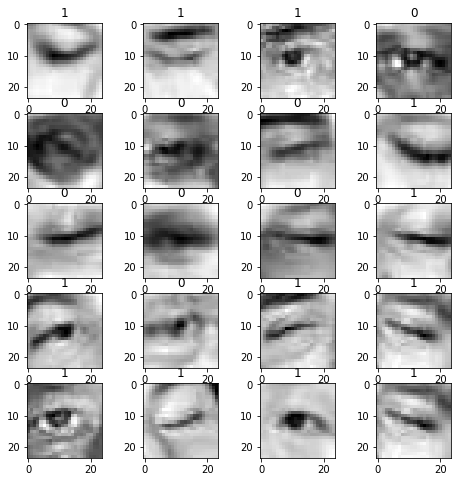

In [187]:
show_results(kmeans, X_test)

# PCA + k-means

In [189]:
pca = PCA(n_components=2)
pca.fit(X_train)

PCA(n_components=2)

In [190]:
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [191]:
kmeans_pca = KMeans(n_clusters=2, random_state=0).fit(X_train_pca)

In [192]:
labels = kmeans_pca.predict(X_test_pca)

In [193]:
centers = kmeans_pca.cluster_centers_

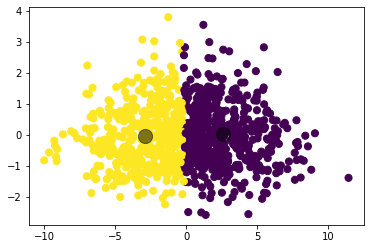

In [194]:
fig = plt.figure()
ax1 = fig.add_subplot(111)

ax1.scatter(X_test_pca[:, 0], X_test_pca[:, 1], c=labels,
            s=50, cmap='viridis')
ax1.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)


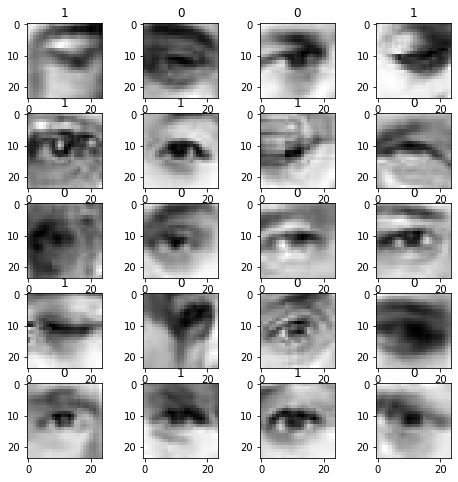

In [195]:
show_results(kmeans_pca, X_test_pca)

# TSNE + k-means

In [201]:
tsne = TSNE(n_components=2, init='random', random_state=23)

In [ ]:
digits_proj = tsne.fit_transform(digits.data)

# Deep approach

In [4]:
class EyesDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        
        transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) 
        ])
        # аугментация трейна для увеличения трейн выборки
        
        augmentation = transforms.Compose([
            transforms.RandomHorizontalFlip(),
            transforms.RandomResizedCrop(224, scale=(0.8, 1), ratio=(0.75, 1.3333333333333333), interpolation=2),
            transforms.RandomPerspective(distortion_scale=0.3, p=0.9, interpolation=3, fill=0),
            transforms.RandomAffine(degrees=20, shear=20, resample=False),
            transforms.Resize((224, 224))
        ])
        
        x = self.load_sample(self.files[index])
        if self.mode == 'train':
            x = augmentation(x)
        x = self._prepare_sample(x)
        x = np.array(x / 255, dtype='float32')
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y
        
    def _prepare_sample(self, image):
        image = image.resize((RESCALE_SIZE, RESCALE_SIZE))
        return np.array(image)

In [5]:
def imshow(inp, title=None, plt_ax=plt, default=False):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt_ax.imshow(inp)
    if title is not None:
        plt_ax.set_title(title)
    plt_ax.grid(False)

Ниже необходимо поменять пусть к train и test данным.

NameError: name 'TRAIN_DIR' is not defined

In [7]:
from sklearn.model_selection import train_test_split

train_val_labels = [path.parent.name for path in train_val_files]
train_files, val_files = train_test_split(train_val_files, test_size=0.25, stratify=train_val_labels)

NameError: name 'train_val_files' is not defined

In [9]:
val_dataset = SimpsonsDataset(val_files, mode='val')

Давайте посмотрим на наших героев внутри датасета.

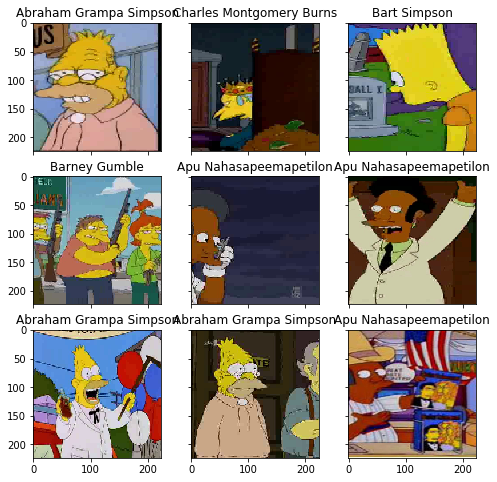

In [10]:
fig, ax = plt.subplots(nrows=3, ncols=3,figsize=(8, 8), \
                        sharey=True, sharex=True)
for fig_x in ax.flatten():
    random_characters = int(np.random.uniform(0,1000))
    im_val, label = val_dataset[random_characters]
    img_label = " ".join(map(lambda x: x.capitalize(),\
                val_dataset.label_encoder.inverse_transform([label])[0].split('_')))
    imshow(im_val.data.cpu(), \
          title=img_label,plt_ax=fig_x)